# Adaptive GAN for MNIST



---
---
## Imports

In [1]:
%matplotlib inline
import sys
sys.path.append("..")

import os
import datetime
from tqdm import tqdm
import matplotlib.pyplot as plt

# TF libs
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

# Utility functions from ../libs
from libs.layers.sn_layer import SNConv2D, SNLinear
from libs.losses.losses import masked_cross_entropy
from libs.utils.plotting import plot_images, plot_losses

# Local scripts
from dataset import Mnist
from discriminator import Discriminator
from generator import Generator
from classifier import build_classifier

In [2]:
tf.__version__

'1.14.1-dev20190426'

---
---
## Build model

+ attack weight is  the weight to balance the loss of GAN and the loss of attacking, which is tuned by trial
+ mask weight is the weight to balance the loss of successfully-attacking samples and failed samples
+ attack taget can only be one number at one time

In [3]:
# Hyper-parameters
mask_weight = 1
attack_weight = tf.placeholder(tf.float32, None, name="attack-weight")

In [4]:
# Placeholders
z = tf.placeholder(tf.float32, shape=[None, 100], name="noise")
y = tf.placeholder(tf.float32, shape=[None, 10], name="label")
x = tf.placeholder(tf.float32, shape=[None, 28, 28, 1], name="real-image")
dis_target = tf.placeholder(tf.float32, shape=[None, 1], name="discriminator-target") # Whether the image is fake of real    
is_training = tf.placeholder(tf.bool)
attack_target =  tf.placeholder(tf.int64, [None], name="attack-target")

In [ ]:
# Create generator and discriminator model
generator = Generator()
discriminator = Discriminator()
classifier = build_classifier()

# Generator and discriminator outputs
fake_img = generator(z, y, is_training)
d_fake_src, d_fake_cls = discriminator(fake_img, y)  # src: whether the image is real or fake; cls: the class of image
d_real_src, d_real_cls = discriminator(x, y)

# Calculate loss
d_loss_source = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_real_src, labels=dis_target))
d_loss_class = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits_v2(logits=d_real_cls, labels=y))
g_loss_source = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_src, labels=dis_target))
g_loss_class = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits_v2(logits=d_fake_cls, labels=y))

# Calculate attack loss    
classifier_output = classifier(fake_img)
attack_losses = tf.losses.sparse_softmax_cross_entropy(attack_target, classifier_output)
classifier_preds = tf.math.argmax(classifier_output, axis=-1)
attack_loss = masked_cross_entropy(attack_losses, classifier_preds, attack_target, mask_weight)

W0609 17:12:11.630073 139993835505408 deprecation_wrapper.py:119] From /home/doublebite/Adaptive Gan/mnist/generator.py:6: The name tf.layers.Dense is deprecated. Please use tf.compat.v1.layers.Dense instead.

W0609 17:12:11.634173 139993835505408 deprecation_wrapper.py:119] From /home/doublebite/Adaptive Gan/mnist/generator.py:7: The name tf.layers.BatchNormalization is deprecated. Please use tf.compat.v1.layers.BatchNormalization instead.

W0609 17:12:11.637320 139993835505408 deprecation_wrapper.py:119] From /home/doublebite/Adaptive Gan/mnist/generator.py:11: The name tf.layers.Conv2DTranspose is deprecated. Please use tf.compat.v1.layers.Conv2DTranspose instead.

W0609 17:12:11.643580 139993835505408 deprecation.py:506] From /home/doublebite/anaconda3/envs/NLU/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for up

<tf.Variable 'discriminator/sn_conv2d/kernel:0' shape=(5, 5, 11, 10) dtype=float32>
<tf.Variable 'discriminator/sn_conv2d_1/kernel:0' shape=(5, 5, 20, 64) dtype=float32>


In [ ]:
# Get training ops
trainable_vars = tf.trainable_variables()
d_var = [var for var in trainable_vars if 'discriminator' in var.name]
g_var = [var for var in trainable_vars if 'generator' in var.name]

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
d_update_ops = [op for op in update_ops if 'discriminator' in op.name]
g_update_ops = [op for op in update_ops if 'generator' in op.name]

d_optimizer = tf.train.AdamOptimizer(learning_rate=2e-4)
g_optimizer = tf.train.AdamOptimizer(learning_rate=2e-4)

with tf.control_dependencies(d_update_ops):
    train_op_D = d_optimizer.minimize(d_loss_source + d_loss_class , var_list=d_var)
with tf.control_dependencies(g_update_ops):
    train_op_G = g_optimizer.minimize(g_loss_source + g_loss_class + attack_weight*attack_loss , var_list=g_var)    

---
---
## Experiment

Note: change the number of target to swtich to different attack target

In [ ]:
# The attack target
target = 0

# Create result dataset
result_dir = "results/mnist_{}".format(str(datetime.datetime.now()))
os.makedirs(result_dir)

In [ ]:
# Initialize sess
sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())    

# Load classifier weight
classifier.load_weights("target_classifier.h5")

In [ ]:
mnist = Mnist()    
noise_size = 100
batch_size = 100
num_batches = 60000 // batch_size
epochs = 70
# epochs = 5

In [ ]:
def increasing_attack_weight(epoch):
    
    return max(1, 100 -  2*epoch)

Epoch 0 of 70
100%|██████████| 600/600 [00:26<00:00, 23.05it/s]
Epoch 1 of 70
100%|██████████| 600/600 [00:22<00:00, 26.47it/s]
Epoch 2 of 70
100%|██████████| 600/600 [00:22<00:00, 26.29it/s]
Epoch 3 of 70
100%|██████████| 600/600 [00:23<00:00, 26.58it/s]
Epoch 4 of 70
100%|██████████| 600/600 [00:23<00:00, 25.86it/s]


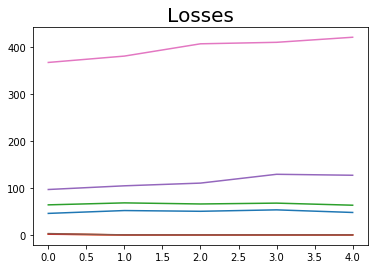

Epoch 5 of 70
100%|██████████| 600/600 [00:22<00:00, 26.57it/s]
Epoch 6 of 70
100%|██████████| 600/600 [00:23<00:00, 25.78it/s]
Epoch 7 of 70
100%|██████████| 600/600 [00:23<00:00, 25.98it/s]
Epoch 8 of 70
100%|██████████| 600/600 [00:23<00:00, 25.96it/s]
Epoch 9 of 70
100%|██████████| 600/600 [00:23<00:00, 25.63it/s]


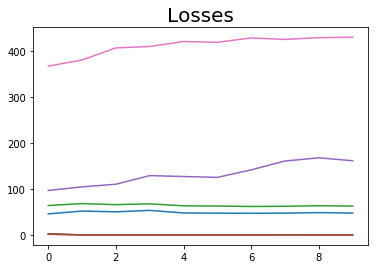

Epoch 10 of 70
100%|██████████| 600/600 [00:22<00:00, 26.09it/s]
Epoch 11 of 70
100%|██████████| 600/600 [00:23<00:00, 24.26it/s]
Epoch 12 of 70
100%|██████████| 600/600 [00:23<00:00, 25.96it/s]
Epoch 13 of 70
100%|██████████| 600/600 [00:23<00:00, 25.69it/s]
Epoch 14 of 70
100%|██████████| 600/600 [00:23<00:00, 25.70it/s]


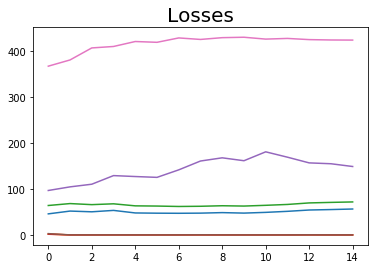

Epoch 15 of 70
100%|██████████| 600/600 [00:23<00:00, 26.73it/s]
Epoch 16 of 70
100%|██████████| 600/600 [00:23<00:00, 22.58it/s]
Epoch 17 of 70
100%|██████████| 600/600 [00:23<00:00, 26.02it/s]
Epoch 18 of 70
 98%|█████████▊| 591/600 [00:22<00:00, 24.49it/s]

In [ ]:
# Preparations before training
np.random.seed(1337)
noise_fixed = np.random.normal(0, 0.5, (100, noise_size))
labels_fixed = np.eye(10)[np.repeat(range(10),[10])]
attack_fixed = np.array([target]*batch_size*2)

# Lists for recording the losses 
losses_d_real_src = []
losses_d_real_cls = []
losses_d_fake_src = []
losses_d_fake_cls = []
losses_g_src = []
losses_g_cls = []
losses_attack = []

### Start experiment
for epoch in range(epochs):
    
    print('===========================================')
    print('Epoch {} of {}'.format(epoch, epochs))
    
    
    tmp_real_src = []
    tmp_real_cls = []
    tmp_fake_src = []
    tmp_fake_cls = []
    tmp_g_src = []
    tmp_g_cls = []
    tmp_attack = []
    
#     attack_weight_this_epoch = increasing_attack_weight(epoch)
    attack_weight_this_epoch = 0.1


    for batch in tqdm(range(num_batches), file=sys.stdout):


        # Train discriminator
        if batch % 30 != 0:
            # Real -> D
            xs, ys = mnist.get_next_batch(batch_size)
            target_src = np.random.uniform(0.7, 1.2, size=(batch_size,1)) # Soomthing
            loss_src, loss_cls, _ = sess.run([d_loss_source, d_loss_class, train_op_D], feed_dict={x:xs, y:ys, is_training:True, dis_target:target_src})
            tmp_real_src.append(loss_src)
            tmp_real_cls.append(loss_cls)

            # Fake -> D
            z_fake = np.random.normal(0, 0.5, (batch_size, noise_size))
            y_fake = np.eye(10)[np.random.randint(0, 10, batch_size)]
            x_fake = sess.run(fake_img, feed_dict={z:z_fake, y:y_fake, is_training:False})
            target_src = np.random.uniform(0.0, 0.3, size=(batch_size,1))
            loss_src, loss_cls, _ = sess.run([d_loss_source, d_loss_class, train_op_D], feed_dict={x:x_fake, y:y_fake, is_training:True, dis_target:target_src})
            tmp_fake_src.append(loss_src)
            tmp_fake_cls.append(loss_cls)

        else:
            # make the labels noisy for the discriminator to prevent overfitting
            xs, ys = mnist.get_next_batch(batch_size)
            target_src = np.random.uniform(0.0, 0.3, size=(batch_size,1))  # occasionally flip the labels
            loss_src, loss_cls, _ = sess.run([d_loss_source, d_loss_class, train_op_D], feed_dict={x:xs, y:ys, is_training:True, dis_target:target_src})
            tmp_real_src.append(loss_src)
            tmp_real_cls.append(loss_cls)

            z_fake = np.random.normal(0, 0.5, (batch_size, noise_size))
            y_fake = np.eye(10)[np.random.randint(0, 10, batch_size)]
            x_fake = sess.run(fake_img, feed_dict={z:z_fake, y:y_fake, is_training:False})
            target_src = np.random.uniform(0.7, 1.2, size=(batch_size,1))
            loss_src, loss_cls, _ = sess.run([d_loss_source, d_loss_class, train_op_D], feed_dict={x:x_fake, y:y_fake, is_training:True, dis_target:target_src})
            tmp_fake_src.append(loss_src)
            tmp_fake_cls.append(loss_cls)

        # Train generator
        z_gen = np.random.normal(0, 0.5, (2 * batch_size, noise_size))
        y_gen = np.eye(10)[np.random.randint(0, 10, 2 * batch_size)]
        target_src = np.random.uniform(0.7, 1.2, size=(2 * batch_size,1))
        loss_src, loss_cls, loss_atk, _ = sess.run([g_loss_source, g_loss_class, attack_loss, train_op_G], 
                                                               feed_dict={z:z_gen, y:y_gen, is_training:True, dis_target:target_src, attack_target:attack_fixed, attack_weight:1})
        tmp_g_src.append(loss_src)
        tmp_g_cls.append(loss_cls)
        tmp_attack.append(loss_atk)

        
    losses_d_real_src.append(np.mean(tmp_real_src))
    losses_d_real_cls.append(np.mean(tmp_real_cls))
    losses_d_fake_src.append(np.mean(tmp_fake_src))
    losses_d_fake_cls.append(np.mean(tmp_fake_cls))
    losses_g_src.append(np.mean(tmp_g_src))
    losses_g_cls.append(np.mean(tmp_g_cls))
    losses_attack.append(np.mean(tmp_attack))

    # Record the result every five epochs
    if (epoch+1)%5==0:
        generated_images, predictions = sess.run([fake_img, classifier_preds], 
                                                                             feed_dict={z:noise_fixed, y:labels_fixed, is_training:True, attack_target:attack_fixed})
        generated_images = generated_images.squeeze() # (N, 28, 28, 1) --> (N, 28, 28)
        plot_images(generated_images, epoch, result_dir=result_dir)
        with open(result_dir + "/result.txt", 'a') as f:
            print("Epochs:", epoch, file=f)            
            print(predictions, file=f)
            print("", file=f)            
        plt.title('Losses', fontsize=20)
        plt.plot(np.array(losses_d_real_src), label="d_loss_real_src")
        plt.plot(np.array(losses_d_real_cls), label="d_loss_real_cls")
        plt.plot(np.array(losses_d_fake_src), label="d_loss_fake_src")
        plt.plot(np.array(losses_d_fake_cls), label="d_loss_fake_cls")
        plt.plot(np.array(losses_g_src), label="g_loss_src")
        plt.plot(np.array(losses_g_cls), label="g_loss_cls")
        plt.plot(np.array(losses_attack), label="attck_loss")
#         plt.legend()
        plt.show()    
